# Bayesian Linear Regression with Metropolis-Hastings

Bayesian formulation of Linear Regression: 
$$
Y | X \sim \mathcal{N}(w^T X, \sigma^2 I)
$$

The  model is now defined as a posterior probabilisic distribution, found by combining the prior and the likelihood from training data:
$$
p(w | X, y) = \frac{p(y,X | w) p(w)}{p(y, X)}
$$

Since we may not be able to directly compute the posterior, we use a sampling method, such as Monte Carlo Markov Chain (MCMC) to sample from the posterior distribution.

### Metropolis-Hastings

1. Inizialize $w^{(1)}$ to some value

2. For $t = 1, \dots, T$:
    1. Sample $w'$ from a proposal distribution $q(w' | w^{(t-1)})$
    2. Compute the acceptance ratio $\alpha = min(1,\frac{p(w'| X, y)}{p(w^{(t-1)} | X, y)}\frac{q(w^{(t-1)}|w')}{q(w'|w^{(t-1)})} )$
    3. Sample $u \sim \mathcal{U}(0,1)$
    4. If $u < \alpha$, set $w^{(t)} = w^*$, otherwise set $w^{(t)} = w^{(t-1)}$


Simplifying assumption: by making use of a symmetric distribution for the proposal distribution, we can simplify the acceptance ratio such that $$\frac{q(w^{(t-1)}|w')}{q(w'|w^{(t-1)})} = 1$$ and $$\alpha = min(1,\frac{p(w'| X, y)}{p(w^{(t-1)} | X, y)})$$. In this case a Gaussian distribution is used for the proposal distribution.

### Proposal distribution

As a proposal distribution for w, we use a Gaussian distribution with mean $w^{(t-1)}$ and covariance matrix $k^2 I$, such that
$$
w' \sim \mathcal{N}(w^{(t-1)}, k^2 I)
$$

### Acceptance ratio

We can substitute the posterior distribution into the acceptance ratio, knowing that  $$p(w^{(t-1)} | X, y) = \frac{p(y,X | w^{(t-1)}) p(w^{(t-1)})}{p(y, X)}$$ and $$p(w' | X, y) = \frac{p(y,X | w') p(w')}{p(y, X)}$$

such that the acceptance ratio becomes
$$
\alpha = min(1,\frac{p(y,X | w') p(w')}{p(y,X | w^{(t-1)}) p(w^{(t-1)})})
$$

For numerical stability, we can take the log of the acceptance ratio, such that
$$
\log(\alpha)  = min(0,\log(p(y,X | w') p(w')) - \log(p(y,X | w^{(t-1)}) p(w^{(t-1)}))) = \\
= min(0,\log(p(y,X | w')) + \log(p(w')) - \log(p(y,X | w^{(t-1)}) - \log(p(w^{(t-1)}))))
$$
The probability of proposal acceptance will be then computed as the exponential of $log(\alpha)$.

The likelihood density can be rewritten assuming independence between the data points and using the Gaussian distribution for the likelihood:
$$
y | X, w \sim \mathcal{N}(X w, \sigma^2 I)
$$, therefore
$$
p(y,X | w) = \prod_{i=1}^N \mathcal{N}(y_i | w^T x_i, \sigma^2)
$$

For the prior, we use a Gaussian distribution with mean 0 and covariance matrix $\tau^2 I$, such that
$$
p(w) = \mathcal{N}(w | 0, \tau^2 I)
$$


## Implementation

In [25]:
supress_warnings = True
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc

In [26]:
def proposal(mean, std):
    """Proposal distribution for the Metropolis-Hastings algorithm, 
        returning a sample from a multivariate Gaussian."""
    return sc.multivariate_normal(mean=mean, cov=np.eye(2)*std**2).rvs(1)

def prior(w, prior_mean, prior_cov):
    """Prior distribution for the model parameters"""
    prior_out = sc.multivariate_normal.logpdf(w,mean=prior_mean,cov=prior_cov,allow_singular=True)
    return prior_out

def likelihood(w, x, y, sigma):
    """Likelihood function for the model parameters"""
    likelihood_out = np.sum(sc.norm.logpdf(y,loc=np.dot(x,w),scale=sigma))
    return likelihood_out
    

In [35]:
def metropolis_hastings(num_steps, x,y, mean, cov, sigma ,proposal_std,burn_in=0):

    samples = np.zeros((num_steps, 2))
    samples[0] = np.random.uniform(-1, 1, 2) # initialize the first sample
    accept_count = 0
    for i in range(1, num_steps):
        new_sample = proposal(samples[i-1], proposal_std)
       
        #Compute the acceptance probability
        log_prior_new = prior(new_sample, mean, cov)
        log_prior_old = prior(samples[i-1], mean, cov)
        log_likelihood_new = likelihood(new_sample, x, y, sigma)
        log_likelihood_old = likelihood(samples[i-1], x, y, sigma)
        proposal_ratio = np.exp(log_prior_new + log_likelihood_new - log_prior_old - log_likelihood_old)

        accep_p = min(1, proposal_ratio)
                
        # accept or reject the new sample
        if np.random.uniform(0, 1) < accep_p:
            samples[i] = new_sample
            if (i > int(burn_in*num_steps)):
                accept_count += 1
        else:
            samples[i] = samples[i-1]

    accept_rate = np.around(accept_count / num_steps, 3)
    return samples, accept_rate

### Build dataset

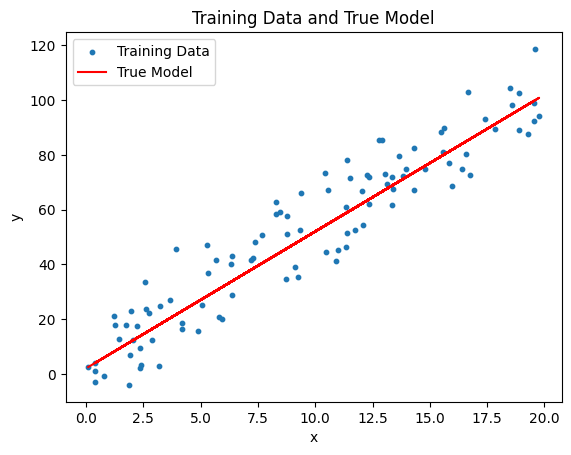

In [57]:
np.random.seed(0)

true_w = np.array([5.0,2.0])
true_sigma = 10.0

dataset_size = 100

x  = np.random.uniform(0,20,dataset_size)
x  = np.vstack((x,np.ones(dataset_size))).T
y  =  x @ true_w + np.random.normal(0,true_sigma,dataset_size)

plt.scatter(x[:,0],y,s=10,label='Training Data')
plt.plot(x[:,0],x@ true_w,'r',label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data and True Model')
plt.legend()
plt.show()

In [58]:
N = 20000
burn_in = 0.4
proposal_std = 0.5
prior_mean = np.zeros(2)
prior_cov = np.eye(2)*5

samples, rate = metropolis_hastings(N, x,y, prior_mean, prior_cov, true_sigma, proposal_std, burn_in)

print('Acceptance rate: ', rate)

Acceptance rate:  0.123


### Results

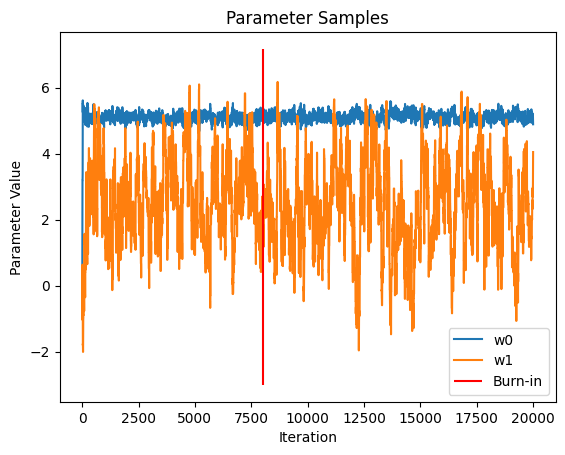

In [59]:
plt.plot(samples[:,0], label='w0')
plt.plot(samples[:,1], label='w1')
max_samples = max(max(samples[:,0]),max(samples[:,1]))
min_samples = min(min(samples[:,0]),min(samples[:,1]))
plt.vlines(x=int(burn_in*N), ymin=min_samples-1, ymax=max_samples+1, color='r', label='Burn-in')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameter Samples')
plt.legend()
plt.show()

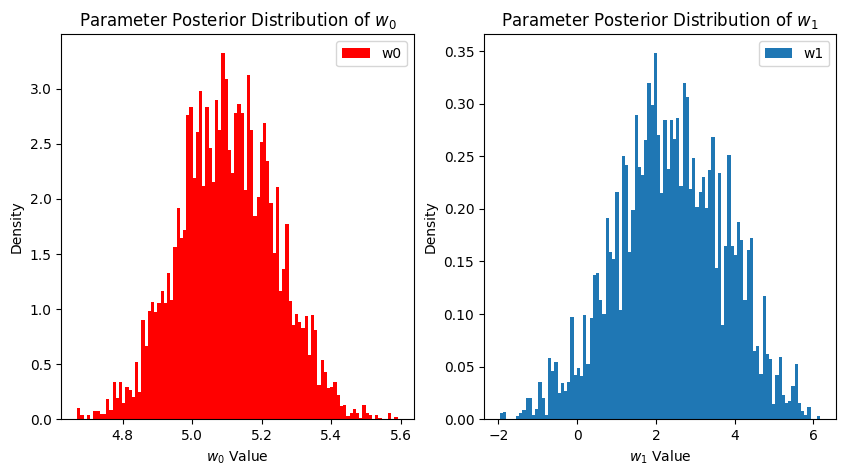

In [70]:
samples_post_burnin = samples[int(burn_in*N):]

fig,axs=plt.subplots(1,2, figsize=(10,5))
axs[0].hist(samples_post_burnin[:,0], bins=100, density=True, label='w0', color='r')
axs[1].hist(samples_post_burnin[:,1], bins=100, density=True, label='w1')
axs[0].set_xlabel('$w_{0}$ Value')
axs[0].set_ylabel('Density')
axs[1].set_xlabel('$w_{1}$ Value')
axs[1].set_ylabel('Density')
axs[0].set_title('Parameter Posterior Distribution of $w_{0}$')
axs[1].set_title('Parameter Posterior Distribution of $w_{1}$')
axs[0].legend()
axs[1].legend()

In [65]:
# Evaluation of mean and standard deviation of the inferred parameters
w0_mean = np.mean(samples_post_burnin[:,0])
w1_mean = np.mean(samples_post_burnin[:,1])
w0_std = np.std(samples_post_burnin[:,0])
w1_std = np.std(samples_post_burnin[:,1])
print('w0 mean: {:.2f}'.format(w0_mean))
print('w1 mean: {:.2f}'.format(w1_mean))
print('w0 std: {:.2f}'.format(w0_std))
print('w1 std: {:.2f}'.format(w1_std))


w0 mean: 5.10
w1 mean: 2.38
w0 std: 0.14
w1 std: 1.38


Estimated w:  [5.10295243 2.37795942]


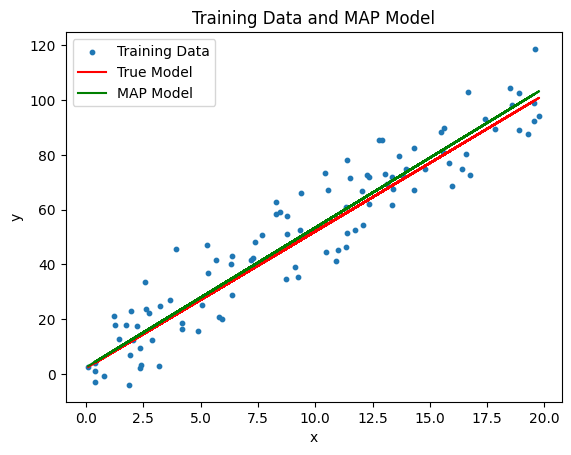

In [61]:
# Compute the MAP estimate (computed as the mean of the samples after burn-in)
w_est = np.mean(samples_post_burnin,axis=0)
print('Estimated w: ', w_est)

plt.scatter(x[:,0],y,s=10,label='Training Data')
plt.plot(x[:,0],x@ true_w,'r',label='True Model')
plt.plot(x[:,0],x@ w_est,'g',label='MAP Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data and MAP Model')
plt.legend()
plt.show()

In [ ]:
#TODO visualize convergence with animation
#TODO add theoretical explanation of what I'm dooing

### References